# 🔳 `l2hmc-qcd` Example: 4D SU(3)

In [1]:
# %matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import os
os.environ['COLORTERM'] = 'truecolor'
import lovely_tensors as lt
lt.monkey_patch()
lt.set_config(color=False)
# automatically detect and reload local changes to modules
%load_ext autoreload
%autoreload 2
import ezpz
import numpy as np
import matplotlib.pyplot as plt
from l2hmc.utils.plot_helpers import FigAxes
import ambivalent
plt.style.use(ambivalent.STYLES['ambivalent'])
#set_plot_style()

[2025-04-30 15:42:06,938] [INFO] [real_accelerator.py:222:get_accelerator] Setting ds_accelerator to mps (auto detect)


W0430 15:42:09.268000 24193 site-packages/torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


Using device: cpu

Failed to download font: IBM Plex Sans, skipping!
Failed to download font: IBM Plex Sans Condensed, skipping!


Failed to download font: IBM Plex Serif, skipping!


In [2]:
import ezpz
from pathlib import Path
from typing import Optional
from rich import print

import lovely_tensors as lt
import matplotlib.pyplot as plt
import numpy as np
import torch
import yaml

# from l2hmc.utils.dist import setup_torch
seed = np.random.randint(2 ** 32)
print(f"seed: {seed}")

_ = ezpz.setup_torch(seed=seed)
torch.set_default_dtype(torch.float64)
# _ = setup_torch(precision='float64', backend='DDP', seed=seed, port='1234')

logger = ezpz.get_logger()

import l2hmc.group.su3.pytorch.group as g
# from l2hmc.utils.rich import get_console
from l2hmc.common import grab_tensor, print_dict
from l2hmc.configs import dict_to_list_of_overrides, get_experiment
from l2hmc.experiment.pytorch.experiment import Experiment, evaluate  # noqa

seed: 3107208906

[2025-04-30 15:42:15][I][ezpz/dist:557] Using get_torch_device_type()='mps' with backend='gloo'

[2025-04-30 15:42:15][I][ezpz/dist:873] Using device='mps' with backend='ddp' + 'gloo' for distributed training.

[2025-04-30 15:42:15][I][ezpz/dist:923] ['Sams-MacBook-Pro-2.local'][0/0]

In [3]:
from l2hmc.utils.plot_helpers import (  # noqa
    plot_scalar,
    plot_chains,
    plot_leapfrogs
)

def savefig(fig: plt.Figure, fname: str, outdir: os.PathLike):
    pngfile = Path(outdir).joinpath(f"pngs/{fname}.png")
    svgfile = Path(outdir).joinpath(f"svgs/{fname}.svg")
    pngfile.parent.mkdir(exist_ok=True, parents=True)
    svgfile.parent.mkdir(exist_ok=True, parents=True)
    fig.savefig(svgfile, transparent=True, bbox_inches='tight')
    fig.savefig(pngfile, transparent=True, bbox_inches='tight', dpi=300)

def plot_metrics(metrics: dict, title: Optional[str] = None, **kwargs):
    outdir = Path(f"./plots-4dSU3/{title}")
    outdir.mkdir(exist_ok=True, parents=True)
    for key, val in metrics.items():
        fig, ax = plot_metric(val, name=key, **kwargs)
        if title is not None:
            ax.set_title(title)
        console.log(f"Saving {key} to {outdir}")
        savefig(fig, f"{key}", outdir=outdir)
        plt.show()

def plot_metric(
        metric: torch.Tensor,
        name: Optional[str] = None,
        **kwargs,
):
    assert len(metric) > 0
    if isinstance(metric[0], (int, float, bool, np.floating)):
        y = np.stack(metric)
        return plot_scalar(y, ylabel=name, **kwargs)
    element_shape = metric[0].shape
    if len(element_shape) == 2:
        y = grab_tensor(torch.stack(metric))
        return plot_leapfrogs(y, ylabel=name)
    if len(element_shape) == 1:
        y = grab_tensor(torch.stack(metric))
        return plot_chains(y, ylabel=name, **kwargs)
    if len(element_shape) == 0:
        y = grab_tensor(torch.stack(metric))
        return plot_scalar(y, ylabel=name, **kwargs)
    raise ValueError

## Load config + build Experiment

In [4]:
from rich import print

from l2hmc.configs import CONF_DIR
su3conf = Path(f"{CONF_DIR}/su3test.yaml")
with su3conf.open('r') as stream:
    conf = dict(yaml.safe_load(stream))

In [5]:
import json
from rich import print_json
print_json(json.dumps(conf, indent=4, sort_keys=True))
overrides = dict_to_list_of_overrides(conf)

{
  "annealing_schedule": {
    "beta_final": 6.0,
    "beta_init": 6.0
  },
  "backend": "DDP",
  "conv": "none",
  "dynamics": {
    "eps": 0.01,
    "eps_fixed": false,
    "group": "SU3",
    "latvolume": [
      4,
      4,
      4,
      4
    ],
    "merge_directions": true,
    "nchains": 8,
    "nleapfrog": 4,
    "use_separate_networks": false,
    "use_split_xnets": false,
    "verbose": true
  },
  "framework": "pytorch",
  "init_aim": false,
  "init_wandb": false,
  "learning_rate": {
    "clip_norm": 1.0,
    "lr_init": "1e-04"
  },
  "loss": {
    "aux_weight": 0.0,
    "charge_weight": 0.0,
    "plaq_weight": 0.1,
    "rmse_weight": 0.1,
    "use_mixed_loss": true
  },
  "net_weights": {
    "v": {
      "q": 1.0,
      "s": 1.0,
      "t": 1.0
    },
    "x": {
      "q": 1.0,
      "s": 0.0,
      "t": 1.0
    }
  },
  "network": {
    "activation_fn": "tanh",
    "dropout_prob": 0.0,
    "units": [
      256
    ],
    "use_batch_norm": false
  },
  "restore": false,
  "save": false,
  "steps": {
    "log": 1,
    "nepoch": 10,
    "nera": 1,
    "print": 1,
    "test": 50
  },
  "use_tb": false,
  "use_wandb": false
}

In [6]:
ptExpSU3 = get_experiment(overrides=[*overrides], build_networks=True)

# console.print(ptExpSU3.config)
state = ptExpSU3.trainer.dynamics.random_state(6.0)
logger.info(f"checkSU(state.x): {g.checkSU(state.x)}")
logger.info(f"checkSU(state.x): {g.checkSU(g.projectSU(state.x))}")
assert isinstance(state.x, torch.Tensor)
assert isinstance(state.beta, torch.Tensor)
assert isinstance(ptExpSU3, Experiment)

[2025-04-30 15:42:54][I][utils/dist:229:l2hmc.utils.dist] Caught MASTER_PORT:1234 from environment!

[2025-04-30 15:42:54][I][utils/dist:229:l2hmc.utils.dist] Caught MASTER_PORT:1234 from environment!

[2025-04-30 15:42:54][W][pytorch/trainer:467:l2hmc.trainers.pytorch.trainer] Using torch.float32 on cpu!

[2025-04-30 15:42:54][W][pytorch/trainer:467:l2hmc.trainers.pytorch.trainer] Using `torch.optim.Adam` optimizer

[2025-04-30 15:42:54][I][pytorch/trainer:305:l2hmc.trainers.pytorch.trainer] num_params in model: 27880456

[2025-04-30 15:42:55][W][pytorch/trainer:271:l2hmc.trainers.pytorch.trainer] logging with freq 1 for wandb.watch

[2025-04-30 15:42:55][I][ipykernel_24193/1455121896:5:ezpz.log] checkSU(state.x): (tensor[8] f64 x∈[1.374e-14, 2.051e-13] μ=5.186e-14 σ=6.363e-14 [2.328e-14, 1.850e-14, 5.587e-14, 2.051e-13, 4.692e-14, 1.374e-14, 1.985e-14, 3.163e-14], tensor[8] f64 x∈[2.012e-13, 6.500e-12] μ=1.497e-12 σ=2.096e-12 [4.096e-13, 4.134e-13, 1.774e-12, 6.500e-12, 1.446e-12, 2.012e-13, 4.689e-13, 7.596e-13])

[2025-04-30 15:42:55][I][ipykernel_24193/1455121896:6:ezpz.log] checkSU(state.x): (tensor[8] f64 x∈[2.705e-16, 2.883e-16] μ=2.798e-16 σ=5.148e-18 [2.763e-16, 2.705e-16, 2.803e-16, 2.883e-16, 2.825e-16, 2.819e-16, 2.804e-16, 2.783e-16], tensor[8] f64 x∈[8.900e-16, 9.337e-16] μ=9.098e-16 σ=1.819e-17 [8.903e-16, 9.331e-16, 9.147e-16, 8.903e-16, 9.337e-16, 9.114e-16, 8.900e-16, 9.147e-16])

In [7]:
# from l2hmc.utils.plot_helpers import set_plot_style
# set_plot_style()

from l2hmc.common import get_timestamp
TSTAMP = get_timestamp()
OUTPUT_DIR = Path(f"./outputs/pt4dSU3/{TSTAMP}")
HMC_DIR = OUTPUT_DIR.joinpath('hmc')
EVAL_DIR = OUTPUT_DIR.joinpath('eval')
TRAIN_DIR = OUTPUT_DIR.joinpath('train')
HMC_DIR.mkdir(exist_ok=True, parents=True)
EVAL_DIR.mkdir(exist_ok=True, parents=True)
TRAIN_DIR.mkdir(exist_ok=True, parents=True)

In [8]:
ptExpSU3.trainer.print_grads_and_weights()
logger.info(ptExpSU3.config)
#console.print(ptExpSU3.config)

[2025-04-30 15:43:03][I][pytorch/trainer:2000:l2hmc.trainers.pytorch.trainer] --------------------------------------------------------------------------------

[2025-04-30 15:43:03][I][pytorch/trainer:2001:l2hmc.trainers.pytorch.trainer] GRADS:

[2025-04-30 15:43:03][I][l2hmc/common:97] networks.xnet.input_layer.xlayer.weight: None None 
None
networks.xnet.input_layer.xlayer.bias: None None 
None
networks.xnet.input_layer.vlayer.weight: None None 
None
networks.xnet.input_layer.vlayer.bias: None None 
None
networks.xnet.scale.coeff: None None 
None
networks.xnet.scale.layer.weight: None None 
None
networks.xnet.scale.layer.bias: None None 
None
networks.xnet.transf.coeff: None None 
None
networks.xnet.transf.layer.weight: None None 
None
networks.xnet.transf.layer.bias: None None 
None
networks.xnet.transl.weight: None None 
None
networks.xnet.transl.bias: None None 
None
networks.vnet.input_layer.xlayer.weight: None None 
None
networks.vnet.input_layer.xlayer.bias: None None 
None
networks.vnet.input_layer.vlayer.weight: None None 
None
networks.vnet.input_layer.vlayer.bias: None None 
None
networks.vnet.scale.coeff: None None 
None
networks.vnet.scale.layer.weight: None None 
None
networks.vnet.scale.layer.bias: None None 
None
networks.vnet.transf.coeff: None None 
None
networks.vnet.transf.layer.weight: None None 
None
networks.vnet.transf.layer.bias: None None 
None
networks.vnet.transl.weight: None None 
None
networks.vnet.transl.bias: None None 
None
xeps.0: None None 
None
xeps.1: None None 
None
xeps.2: None None 
None
xeps.3: None None 
None
veps.0: None None 
None
veps.1: None None 
None
veps.2: None None 
None
veps.3: None None 
None

[2025-04-30 15:43:03][I][pytorch/trainer:2003:l2hmc.trainers.pytorch.trainer] --------------------------------------------------------------------------------

[2025-04-30 15:43:03][I][pytorch/trainer:2004:l2hmc.trainers.pytorch.trainer] WEIGHTS:

[2025-04-30 15:43:03][I][l2hmc/common:97] networks.xnet.input_layer.xlayer.weight: torch.Size([256, 18432]) torch.float64 
[[-4.19951343e-03 -4.26238340e-03  2.35647156e-03 ...  1.68137878e-03
  -1.50068399e-03  3.15863944e-03]
 [ 2.39342553e-04 -4.97551288e-03  7.26050381e-03 ... -5.64728922e-03
  -5.55020874e-03  1.17323965e-03]
 [ 5.26405398e-03 -3.91491501e-03  7.14260998e-04 ... -6.31723398e-03
   5.23567487e-03  2.05607864e-03]
 ...
 [ 6.68730979e-03 -6.91921820e-03  8.95772739e-05 ... -4.07246778e-03
  -2.29316978e-03 -3.43056826e-03]
 [-1.77016491e-03 -1.95781418e-03 -5.01585640e-03 ... -6.46914302e-03
   4.20147742e-03 -7.09234809e-03]
 [-1.94973833e-03 -7.26403514e-03  4.98051500e-04 ... -6.28795095e-03
   6.79912449e-04 -9.21666063e-04]]
networks.xnet.input_layer.xlayer.bias: torch.Size([256]) torch.float64 
[ 3.15653089e-03 -6.53747057e-03 -6.14933637e-03 -5.49529500e-03
 -4.48003873e-03 -7.03491801e-03 -6.56321877e-03  4.67182499e-03
  4.36532234e-03 -5.36476346e-03 -6.09211776e-03 -7.10460550e-03
 -6.52009109e-03 -6.43876671e-03 -1.97297283e-03  5.79927976e-03
 -5.49722940e-03  6.75426645e-03  6.06732313e-03  2.56460577e-03
 -5.80235106e-03  1.03618414e-03  6.36349657e-04  1.60436063e-03
 -3.06399032e-05 -7.50359147e-04  4.36385955e-03  1.00302522e-03
  7.32044498e-03 -1.43824191e-03 -2.50594005e-03 -6.82552956e-03
 -4.71028329e-03  1.71534301e-03  6.10709162e-03 -4.05667409e-03
 -2.30713007e-03 -5.12144947e-03 -7.15109109e-04 -4.44328498e-03
 -4.94695187e-04  3.15081409e-03 -2.37185464e-03 -1.91157742e-03
  6.91548413e-03  3.81991132e-04 -4.31922342e-03 -1.98542428e-03
  4.05912039e-03  1.92396383e-03  3.53810871e-03  6.53665668e-04
 -5.06483635e-04 -5.86019994e-03 -2.86685524e-03 -2.27205811e-03
  7.25025555e-03 -5.94056580e-03 -1.54673733e-03  8.73715266e-04
 -4.36832096e-03  4.80786903e-03  1.69290306e-03 -1.38375220e-03
  6.96793511e-03  5.39967604e-03 -4.38277881e-03  4.86837191e-03
 -4.63730538e-03 -2.72580171e-04  5.81442710e-03  1.45265237e-03
  5.09906755e-03 -5.65087549e-03 -1.40143350e-03 -6.84733200e-03
  1.19933276e-03  7.28487144e-03 -1.88899102e-03 -1.74111447e-03
 -2.23510673e-03  2.73357402e-03 -1.06047067e-03 -5.84367407e-04
 -1.07953771e-03 -7.04448438e-03  3.29054140e-03  1.94660675e-04
 -1.10677934e-03 -2.41696262e-03 -1.78325949e-03  1.03577164e-03
  7.27804628e-03 -5.85394151e-03 -4.49392971e-03 -6.15160667e-03
 -4.20118105e-03  4.69744100e-03 -4.00506019e-03 -3.18274408e-03
  6.46112415e-03  2.89159411e-03  5.58561882e-05 -2.93133409e-03
  8.16798907e-04 -6.32176171e-03  5.56053897e-03 -6.36041217e-04
 -5.79233323e-03  5.06384306e-03 -3.84639758e-03  4.87318855e-03
  2.09912290e-04  4.33691731e-03  3.37906617e-03 -5.05196960e-03
  1.02895130e-03  4.08134740e-03 -1.53992986e-03  2.17678400e-03
 -6.35111539e-03 -5.66248347e-03 -1.10881411e-03 -4.16939110e-03
 -2.41698897e-03  7.25206709e-03  3.52455892e-03 -2.72657199e-03
 -4.46049487e-03  6.27997800e-03  4.12822311e-03 -4.29568963e-03
  3.27822525e-03  4.74422437e-04 -7.36276516e-03  6.08754623e-04
  5.07836316e-03 -2.49084412e-03  6.68436632e-03  1.63677606e-03
 -6.40259777e-03 -3.89026602e-03  5.53970429e-04 -4.87297662e-03
  5.29615772e-03 -7.04606173e-03  3.74678711e-03  3.76877809e-03
  4.02093817e-03 -4.28408453e-04 -5.69630100e-03  7.00086373e-03
 -3.02440694e-03  2.58179140e-03  5.33379816e-03 -6.61146570e-03
  1.48293246e-03  2.37842092e-03 -4.01829177e-03  5.58703024e-03
 -5.74216662e-04  5.99784977e-03 -4.73664072e-03  2.37927320e-03
 -3.39304510e-03 -2.54775472e-03  4.55417377e-03  8.61042071e-04
  5.07867546e-03  5.38944149e-03  8.43247180e-05 -3.12868764e-03
 -1.34245397e-03  6.48412301e-03  7.15439817e-03  1.66651130e-04
  4.06732860e-03  2.83814521e-03  7.24635495e-03  6.22788597e-03
  4.20149888e-03  6.49253302e-04 -3.91114083e-03 -3.58432497e-03
 -3.86471098e-03  2.81108473e-03  1.78824730e-03  1.68233903e-03
  2.84089912e-03  6.25876716e-03 -4.43284225e-03  1.18857102e-03
 -4.23199176e-03  6.52209025e-03  3.10487973e-04 

[2025-04-30 15:43:03][I][pytorch/trainer:2006:l2hmc.trainers.pytorch.trainer] --------------------------------------------------------------------------------

[2025-04-30 15:43:03][I][ipykernel_24193/3178487732:2:ezpz.log] ExperimentConfig(wandb={'setup': {'id': None, 'group': None, 'config': None, 'save_code': True, 'sync_tensorboard': True, 'mode': 'online', 'resume': 'allow', 'entity': 'l2hmc-qcd', 'project': 'l2hmc-qcd', 'settings': {'start_method': 'thread'}, 'tags': ['beta_init=6.0', 'beta_final=6.0']}}, steps=Steps(nera=1, nepoch=10, test=50, log=1, print=1, extend_last_era=1), framework='pytorch', loss=LossConfig(use_mixed_loss=True, charge_weight=0.0, rmse_weight=0.1, plaq_weight=0.1, aux_weight=0.0), network=NetworkConfig(units=[256], activation_fn='tanh', dropout_prob=0.0, use_batch_norm=False), conv=ConvolutionConfig(filters=[], sizes=[], pool=[]), net_weights=NetWeights(x=NetWeight(s=0.0, t=1.0, q=1.0), v=NetWeight(s=1.0, t=1.0, q=1.0)), dynamics=DynamicsConfig(nchains=8, group='SU3', latvolume=[4, 4, 4, 4], nleapfrog=4, eps=0.01, eps_hmc=0.25, use_ncp=True, verbose=True, eps_fixed=False, use_split_xnets=False, use_separate_networks=False, merge_directions=True), learning_rate=LearningRateConfig(lr_init=0.0001, mode='auto', monitor='loss', patience=5, cooldown=0, warmup=1000, verbose=True, min_lr=1e-06, factor=0.98, min_delta=0.0001, clip_norm=1.0), annealing_schedule=AnnealingSchedule(beta_init=6.0, beta_final=6.0, dynamic=False), gradient_accumulation_steps=1, restore=False, save=False, c1=0.0, port='2345', compile=True, profile=False, init_aim=False, init_wandb=False, use_wandb=False, use_tb=False, debug_mode=False, default_mode=True, print_config=True, precision='float32', ignore_warnings=True, backend='DDP', seed=9992, ds_config_path='/Users/samforeman/projects/saforem2/l2hmc-qcd/src/l2hmc/conf/ds_config.yaml', name=None, width=200, nchains=None, compression=False)

## HMC

In [9]:
xhmc, history_hmc = evaluate(
    nsteps=50,
    exp=ptExpSU3,
    beta=6.0,
    x=state.x,
    eps=0.1,
    nleapfrog=8,
    job_type='hmc',
    nlog=1,
    nprint=50,
    grab=True
)

[2025-04-30 15:43:31][I][pytorch/experiment:117:l2hmc.experiment.pytorch.experiment] Running 50 steps of hmc at beta=6.0000

[2025-04-30 15:43:31][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 0

[2025-04-30 15:43:31][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 1

[2025-04-30 15:43:31][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 2

[2025-04-30 15:43:32][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 3

[2025-04-30 15:43:32][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 4

[2025-04-30 15:43:32][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 5

[2025-04-30 15:43:32][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 6

[2025-04-30 15:43:33][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 7

[2025-04-30 15:43:33][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 8

[2025-04-30 15:43:33][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 9

[2025-04-30 15:43:33][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 10

[2025-04-30 15:43:34][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 11

[2025-04-30 15:43:34][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 12

[2025-04-30 15:43:34][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 13

[2025-04-30 15:43:34][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 14

[2025-04-30 15:43:34][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 15

[2025-04-30 15:43:35][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 16

[2025-04-30 15:43:35][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 17

[2025-04-30 15:43:35][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 18

[2025-04-30 15:43:35][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 19

[2025-04-30 15:43:36][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 20

[2025-04-30 15:43:36][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 21

[2025-04-30 15:43:36][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 22

[2025-04-30 15:43:36][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 23

[2025-04-30 15:43:37][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 24

[2025-04-30 15:43:37][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 25

[2025-04-30 15:43:37][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 26

[2025-04-30 15:43:37][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 27

[2025-04-30 15:43:38][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 28

[2025-04-30 15:43:38][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 29

[2025-04-30 15:43:38][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 30

[2025-04-30 15:43:38][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 31

[2025-04-30 15:43:39][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 32

[2025-04-30 15:43:39][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 33

[2025-04-30 15:43:39][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 34

[2025-04-30 15:43:39][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 35

[2025-04-30 15:43:40][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 36

[2025-04-30 15:43:40][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 37

[2025-04-30 15:43:40][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 38

[2025-04-30 15:43:40][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 39

[2025-04-30 15:43:41][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 40

[2025-04-30 15:43:41][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 41

[2025-04-30 15:43:41][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 42

[2025-04-30 15:43:41][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 43

[2025-04-30 15:43:42][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 44

[2025-04-30 15:43:42][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 45

[2025-04-30 15:43:42][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 46

[2025-04-30 15:43:42][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 47

[2025-04-30 15:43:43][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 48

[2025-04-30 15:43:43][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 49

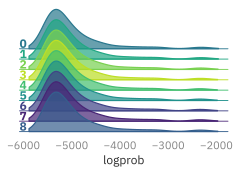

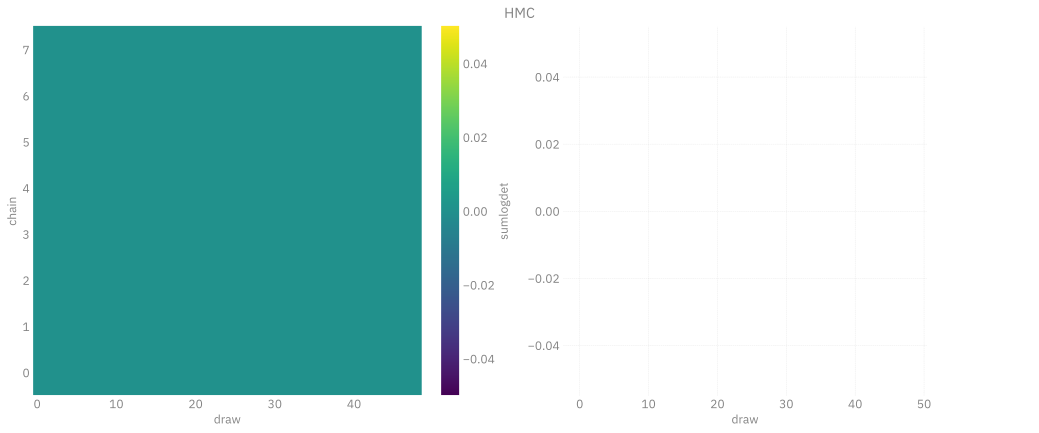

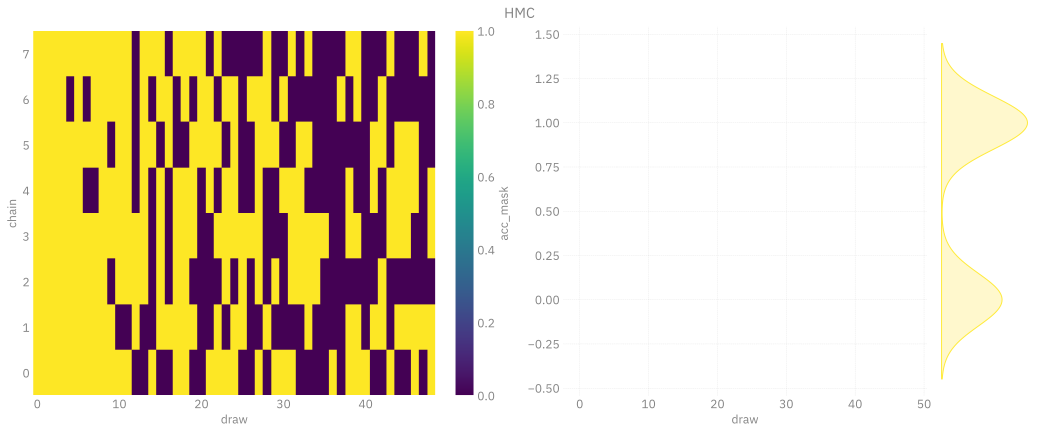

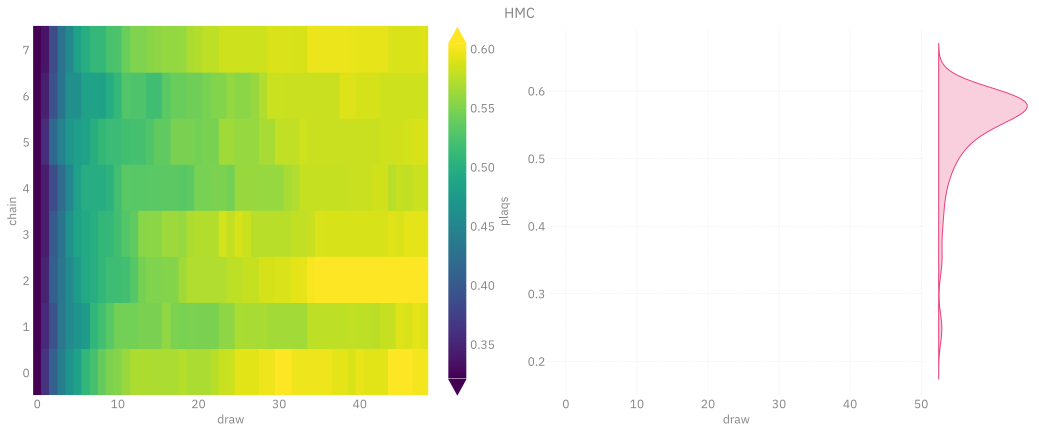

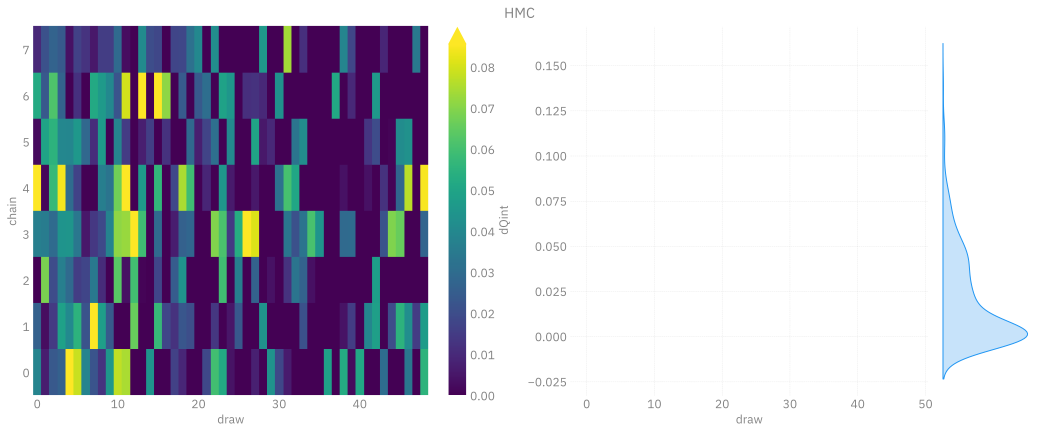

In [10]:
dataset_hmc = history_hmc.get_dataset()
_ = history_hmc.plot_all(title='HMC')

In [11]:
xhmc = ptExpSU3.trainer.dynamics.unflatten(xhmc)
print(f"checkSU(x_eval): {g.checkSU(xhmc)}")
print(f"checkSU(x_eval): {g.checkSU(g.projectSU(xhmc))}")

checkSU(x_eval): (tensor[8] f64 x∈[2.314e-16, 5.581e-16] μ=3.985e-16 σ=1.437e-16 [5.220e-16, 5.581e-16, 2.338e-16, 
5.152e-16, 5.239e-16, 2.825e-16, 2.314e-16, 3.214e-16], tensor[8] f64 x∈[6.633e-16, 1.660e-15] μ=1.198e-15 
σ=3.983e-16 [1.438e-15, 1.657e-15, 6.633e-16, 1.660e-15, 1.449e-15, 8.822e-16, 8.161e-16, 1.014e-15])

checkSU(x_eval): (tensor[8] f64 x∈[2.099e-16, 3.202e-16] μ=2.785e-16 σ=4.123e-17 [3.078e-16, 3.202e-16, 2.099e-16, 
3.114e-16, 3.049e-16, 2.593e-16, 2.294e-16, 2.850e-16], tensor[8] f64 x∈[7.639e-16, 9.703e-16] μ=8.714e-16 
σ=8.022e-17 [9.119e-16, 9.703e-16, 7.805e-16, 9.469e-16, 9.134e-16, 7.639e-16, 7.940e-16, 8.903e-16])

## Training

In [12]:
import time
from l2hmc.utils.history import BaseHistory, summarize_dict

history_train = BaseHistory()
x = state.x
for step in range(100):
    # log.info(f'HMC STEP: {step}')
    tic = time.perf_counter()
    x, metrics_ = ptExpSU3.trainer.train_step(
        (x, state.beta)
    )
    toc = time.perf_counter()
    metrics = {
        'train_step': step,
        'dt': toc - tic,
        **metrics_,
    }
    if step % 5 == 0:
        avgs = history_train.update(metrics)
        summary = summarize_dict(avgs)
        logger.info(summary)

[2025-04-30 15:45:44][I][ipykernel_24193/30352159:21:ezpz.log] train_step=0 dt=1.577 energy=33.403 logprob=33.488 logdet=-0.085 sldf=-0.065 sldb=0.086 sld=-0.085 xeps=0.010 veps=0.010 acc=0.131 sumlogdet=0.000 beta=6.000 acc_mask=0.000 loss=88.118 plaqs=-0.004 sinQ=-0.002 intQ=-0.026 dQint=0.000 dQsin=0.000

[2025-04-30 15:45:51][I][ipykernel_24193/30352159:21:ezpz.log] train_step=5 dt=1.256 energy=-372.669 logprob=-372.955 logdet=0.285 sldf=0.191 sldb=-0.217 sld=0.285 xeps=0.010 veps=0.010 acc=1.000 sumlogdet=-0.091 beta=6.000 acc_mask=1.000 loss=-647.866 plaqs=0.038 sinQ=-0.002 intQ=-0.034 dQint=0.009 dQsin=0.001

[2025-04-30 15:45:58][I][ipykernel_24193/30352159:21:ezpz.log] train_step=10 dt=1.308 energy=-780.851 logprob=-781.247 logdet=0.396 sldf=0.254 sldb=-0.276 sld=0.396 xeps=0.011 veps=0.010 acc=0.952 sumlogdet=-0.044 beta=6.000 acc_mask=1.000 loss=-538.541 plaqs=0.088 sinQ=-0.002 intQ=-0.036 dQint=0.017 dQsin=0.001

[2025-04-30 15:46:05][I][ipykernel_24193/30352159:21:ezpz.log] train_step=15 dt=1.487 energy=-1234.642 logprob=-1235.128 logdet=0.486 sldf=0.303 sldb=-0.298 sld=0.486 xeps=0.011 veps=0.010 acc=1.000 sumlogdet=0.011 beta=6.000 acc_mask=1.000 loss=-617.539 plaqs=0.134 sinQ=-0.003 intQ=-0.038 dQint=0.022 dQsin=0.002

[2025-04-30 15:46:13][I][ipykernel_24193/30352159:21:ezpz.log] train_step=20 dt=1.424 energy=-1559.334 logprob=-1559.934 logdet=0.600 sldf=0.370 sldb=-0.363 sld=0.600 xeps=0.012 veps=0.010 acc=1.000 sumlogdet=0.029 beta=6.000 acc_mask=1.000 loss=-450.278 plaqs=0.169 sinQ=0.000 intQ=0.005 dQint=0.016 dQsin=0.001

[2025-04-30 15:46:20][I][ipykernel_24193/30352159:21:ezpz.log] train_step=25 dt=1.611 energy=-1901.485 logprob=-1902.100 logdet=0.615 sldf=0.383 sldb=-0.382 sld=0.615 xeps=0.012 veps=0.010 acc=0.766 sumlogdet=0.082 beta=6.000 acc_mask=0.625 loss=-306.696 plaqs=0.203 sinQ=-0.001 intQ=-0.018 dQint=0.013 dQsin=0.001

[2025-04-30 15:46:28][I][ipykernel_24193/30352159:21:ezpz.log] train_step=30 dt=1.358 energy=-2024.281 logprob=-2025.102 logdet=0.821 sldf=0.522 sldb=-0.530 sld=0.821 xeps=0.013 veps=0.010 acc=0.751 sumlogdet=-0.083 beta=6.000 acc_mask=0.750 loss=-136.896 plaqs=0.224 sinQ=0.001 intQ=0.016 dQint=0.012 dQsin=0.001

[2025-04-30 15:46:36][I][ipykernel_24193/30352159:21:ezpz.log] train_step=35 dt=1.532 energy=-2218.666 logprob=-2219.663 logdet=0.997 sldf=0.624 sldb=-0.624 sld=0.997 xeps=0.013 veps=0.011 acc=0.673 sumlogdet=0.001 beta=6.000 acc_mask=0.625 loss=-26.350 plaqs=0.242 sinQ=0.002 intQ=0.033 dQint=0.012 dQsin=0.001

[2025-04-30 15:46:44][I][ipykernel_24193/30352159:21:ezpz.log] train_step=40 dt=1.553 energy=-2388.089 logprob=-2389.183 logdet=1.093 sldf=0.706 sldb=-0.754 sld=1.093 xeps=0.013 veps=0.011 acc=0.386 sumlogdet=-0.040 beta=6.000 acc_mask=0.375 loss=239.300 plaqs=0.259 sinQ=0.002 intQ=0.029 dQint=0.012 dQsin=0.001

[2025-04-30 15:46:52][I][ipykernel_24193/30352159:21:ezpz.log] train_step=45 dt=1.609 energy=-2497.524 logprob=-2498.931 logdet=1.408 sldf=0.886 sldb=-0.906 sld=1.408 xeps=0.013 veps=0.011 acc=0.414 sumlogdet=0.014 beta=6.000 acc_mask=0.375 loss=76.319 plaqs=0.274 sinQ=0.002 intQ=0.026 dQint=0.003 dQsin=0.000

[2025-04-30 15:46:59][I][ipykernel_24193/30352159:21:ezpz.log] train_step=50 dt=1.623 energy=-2696.907 logprob=-2698.606 logdet=1.699 sldf=1.064 sldb=-1.083 sld=1.699 xeps=0.013 veps=0.012 acc=0.665 sumlogdet=0.006 beta=6.000 acc_mask=0.750 loss=-231.184 plaqs=0.293 sinQ=0.002 intQ=0.036 dQint=0.013 dQsin=0.001

[2025-04-30 15:47:07][I][ipykernel_24193/30352159:21:ezpz.log] train_step=55 dt=1.554 energy=-2865.825 logprob=-2867.770 logdet=1.945 sldf=1.209 sldb=-1.215 sld=1.945 xeps=0.013 veps=0.012 acc=0.770 sumlogdet=0.153 beta=6.000 acc_mask=0.750 loss=-210.427 plaqs=0.311 sinQ=0.003 intQ=0.041 dQint=0.016 dQsin=0.001

[2025-04-30 15:47:15][I][ipykernel_24193/30352159:21:ezpz.log] train_step=60 dt=1.709 energy=-2985.928 logprob=-2987.915 logdet=1.987 sldf=1.251 sldb=-1.296 sld=1.987 xeps=0.013 veps=0.012 acc=1.000 sumlogdet=-0.029 beta=6.000 acc_mask=1.000 loss=-278.412 plaqs=0.323 sinQ=0.003 intQ=0.043 dQint=0.010 dQsin=0.001

[2025-04-30 15:47:23][I][ipykernel_24193/30352159:21:ezpz.log] train_step=65 dt=1.557 energy=-3155.115 logprob=-3157.112 logdet=1.997 sldf=1.252 sldb=-1.281 sld=1.997 xeps=0.013 veps=0.013 acc=1.000 sumlogdet=0.006 beta=6.000 acc_mask=1.000 loss=-363.215 plaqs=0.342 sinQ=0.002 intQ=0.025 dQint=0.021 dQsin=0.001

[2025-04-30 15:47:30][I][ipykernel_24193/30352159:21:ezpz.log] train_step=70 dt=1.474 energy=-3309.328 logprob=-3311.369 logdet=2.041 sldf=1.279 sldb=-1.318 sld=2.041 xeps=0.013 veps=0.013 acc=1.000 sumlogdet=-0.011 beta=6.000 acc_mask=1.000 loss=-374.258 plaqs=0.360 sinQ=-0.000 intQ=-0.003 dQint=0.018 dQsin=0.001

[2025-04-30 15:47:37][I][ipykernel_24193/30352159:21:ezpz.log] train_step=75 dt=1.599 energy=-3493.874 logprob=-3496.069 logdet=2.195 sldf=1.355 sldb=-1.349 sld=2.195 xeps=0.013 veps=0.014 acc=1.000 sumlogdet=0.130 beta=6.000 acc_mask=1.000 loss=-380.764 plaqs=0.378 sinQ=0.001 intQ=0.022 dQint=0.011 dQsin=0.001

[2025-04-30 15:47:45][I][ipykernel_24193/30352159:21:ezpz.log] train_step=80 dt=1.682 energy=-3625.884 logprob=-3627.857 logdet=1.973 sldf=1.234 sldb=-1.251 sld=1.973 xeps=0.013 veps=0.015 acc=1.000 sumlogdet=0.019 beta=6.000 acc_mask=1.000 loss=-442.163 plaqs=0.396 sinQ=-0.000 intQ=-0.003 dQint=0.020 dQsin=0.001

[2025-04-30 15:47:53][I][ipykernel_24193/30352159:21:ezpz.log] train_step=85 dt=1.588 energy=-3841.913 logprob=-3843.908 logdet=1.995 sldf=1.230 sldb=-1.213 sld=1.995 xeps=0.012 veps=0.015 acc=1.000 sumlogdet=0.146 beta=6.000 acc_mask=1.000 loss=-556.948 plaqs=0.416 sinQ=0.000 intQ=0.004 dQint=0.008 dQsin=0.001

[2025-04-30 15:48:01][I][ipykernel_24193/30352159:21:ezpz.log] train_step=90 dt=1.512 energy=-4034.155 logprob=-4035.872 logdet=1.718 sldf=1.085 sldb=-1.128 sld=1.718 xeps=0.012 veps=0.016 acc=1.000 sumlogdet=-0.056 beta=6.000 acc_mask=1.000 loss=-518.971 plaqs=0.435 sinQ=-0.000 intQ=-0.001 dQint=0.016 dQsin=0.001

[2025-04-30 15:48:09][I][ipykernel_24193/30352159:21:ezpz.log] train_step=95 dt=1.604 energy=-4136.090 logprob=-4137.796 logdet=1.707 sldf=1.071 sldb=-1.091 sld=1.707 xeps=0.012 veps=0.016 acc=1.000 sumlogdet=-0.034 beta=6.000 acc_mask=1.000 loss=-613.025 plaqs=0.455 sinQ=-0.001 intQ=-0.008 dQint=0.012 dQsin=0.001

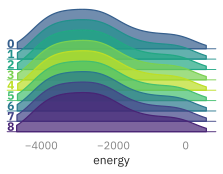

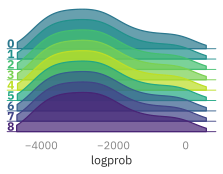

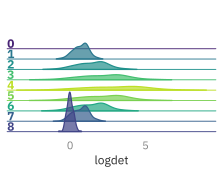

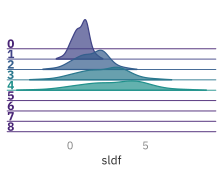

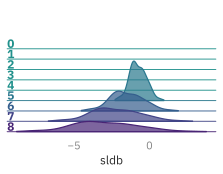

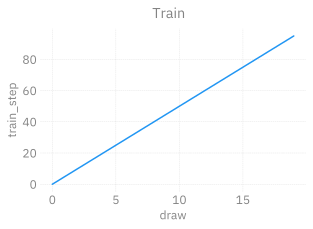

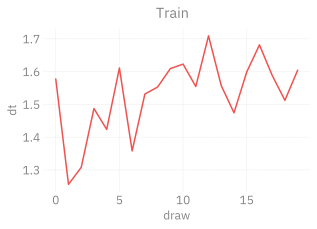

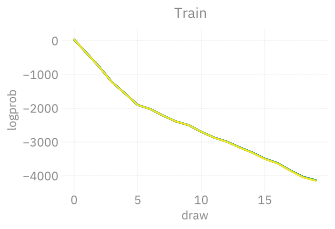

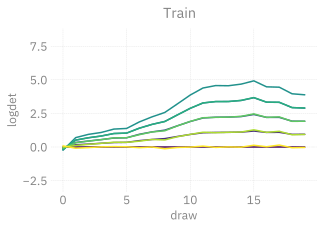

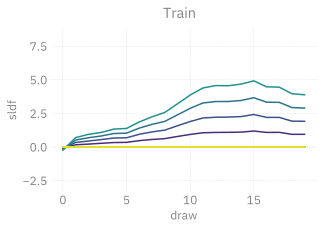

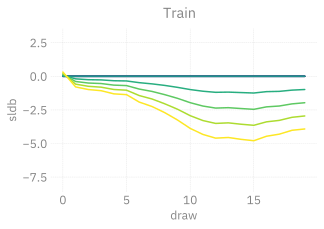

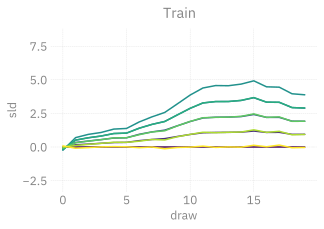

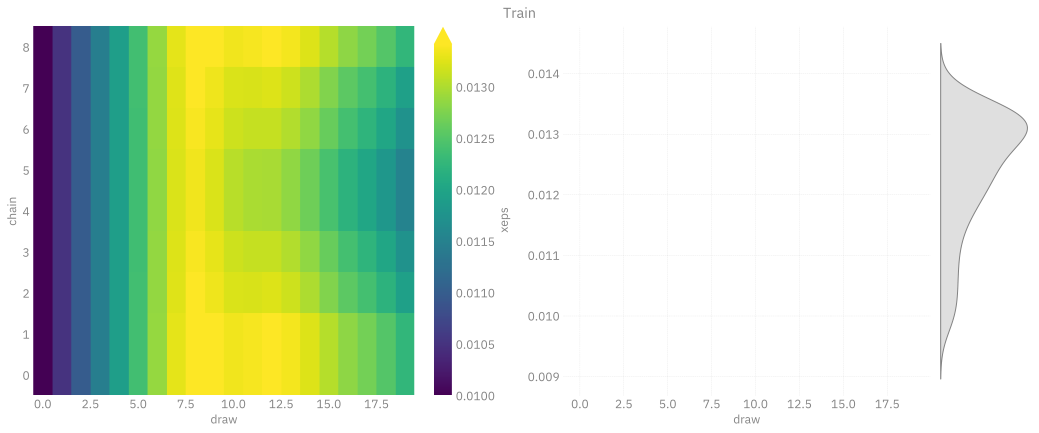

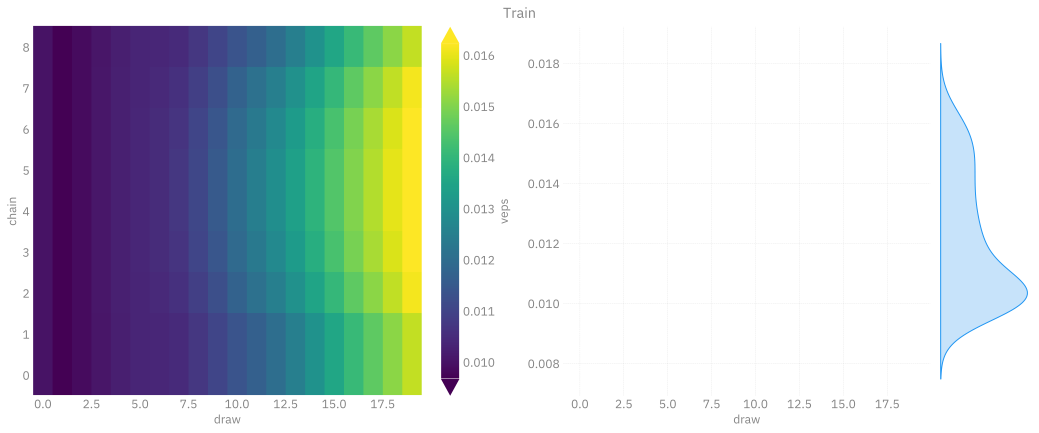

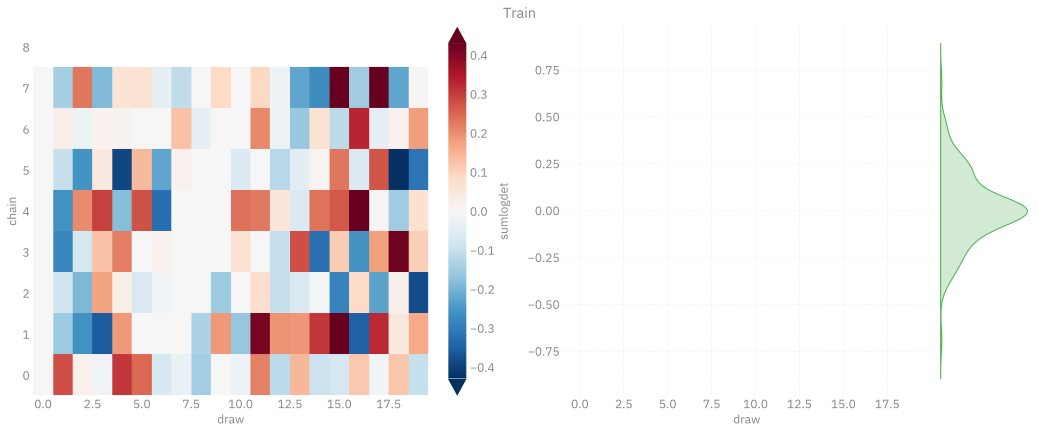

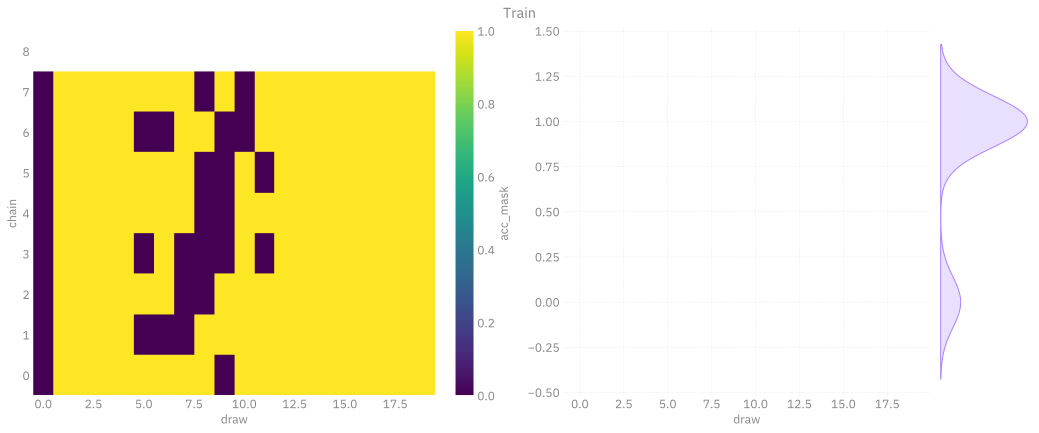

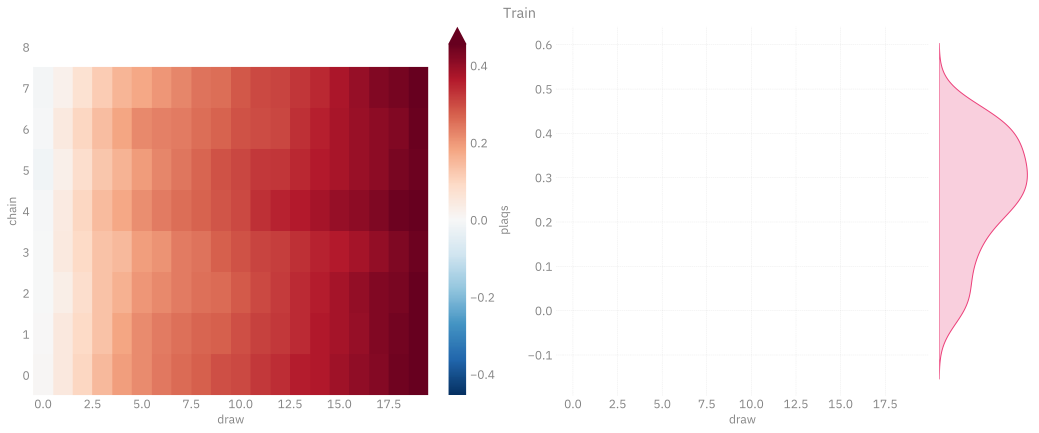

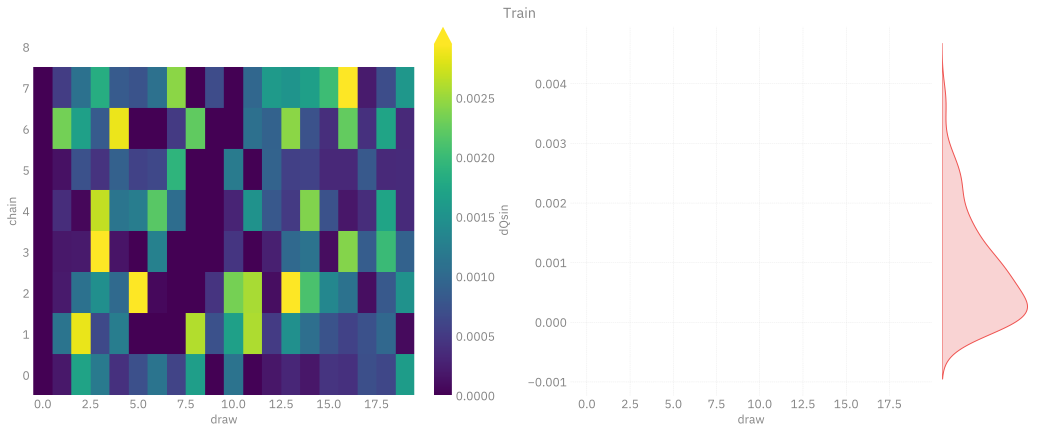

In [13]:
dataset_train = history_train.get_dataset()
_ = history_train.plot_all(
    title='Train',
    num_chains=x.shape[0],
)

## Evaluation

In [14]:
# state = ptExpSU3.trainer.dynamics.random_state(6.0)
xeval, history_eval = evaluate(
    nsteps=50,
    exp=ptExpSU3,
    beta=6.0,
    # x=state.x,
    job_type='eval',
    nlog=1,
    nprint=50,
    grab=True,
)

[2025-04-30 15:56:12][I][pytorch/experiment:117:l2hmc.experiment.pytorch.experiment] Running 50 steps of eval at beta=6.0000

[2025-04-30 15:56:12][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 0

[2025-04-30 15:56:12][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 1

[2025-04-30 15:56:13][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 2

[2025-04-30 15:56:14][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 3

[2025-04-30 15:56:14][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 4

[2025-04-30 15:56:15][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 5

[2025-04-30 15:56:15][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 6

[2025-04-30 15:56:16][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 7

[2025-04-30 15:56:16][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 8

[2025-04-30 15:56:17][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 9

[2025-04-30 15:56:17][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 10

[2025-04-30 15:56:18][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 11

[2025-04-30 15:56:18][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 12

[2025-04-30 15:56:19][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 13

[2025-04-30 15:56:19][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 14

[2025-04-30 15:56:20][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 15

[2025-04-30 15:56:20][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 16

[2025-04-30 15:56:21][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 17

[2025-04-30 15:56:21][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 18

[2025-04-30 15:56:22][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 19

[2025-04-30 15:56:22][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 20

[2025-04-30 15:56:23][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 21

[2025-04-30 15:56:23][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 22

[2025-04-30 15:56:24][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 23

[2025-04-30 15:56:24][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 24

[2025-04-30 15:56:24][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 25

[2025-04-30 15:56:25][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 26

[2025-04-30 15:56:25][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 27

[2025-04-30 15:56:26][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 28

[2025-04-30 15:56:26][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 29

[2025-04-30 15:56:27][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 30

[2025-04-30 15:56:27][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 31

[2025-04-30 15:56:28][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 32

[2025-04-30 15:56:28][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 33

[2025-04-30 15:56:29][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 34

[2025-04-30 15:56:29][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 35

[2025-04-30 15:56:29][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 36

[2025-04-30 15:56:30][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 37

[2025-04-30 15:56:30][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 38

[2025-04-30 15:56:31][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 39

[2025-04-30 15:56:32][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 40

[2025-04-30 15:56:32][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 41

[2025-04-30 15:56:33][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 42

[2025-04-30 15:56:33][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 43

[2025-04-30 15:56:34][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 44

[2025-04-30 15:56:34][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 45

[2025-04-30 15:56:35][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 46

[2025-04-30 15:56:35][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 47

[2025-04-30 15:56:36][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 48

[2025-04-30 15:56:36][I][pytorch/experiment:121:l2hmc.experiment.pytorch.experiment] STEP: 49

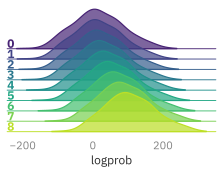

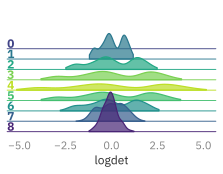

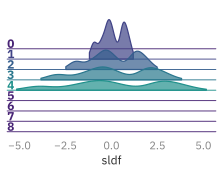

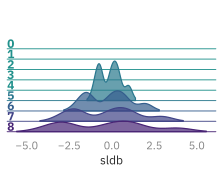

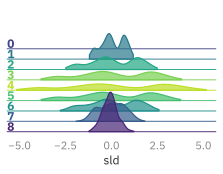

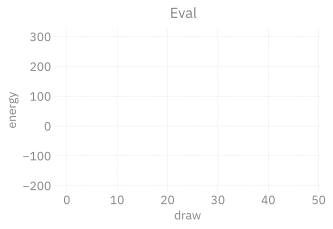

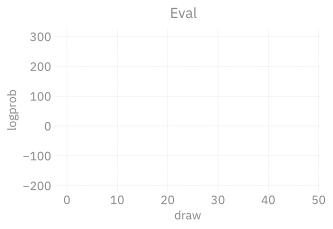

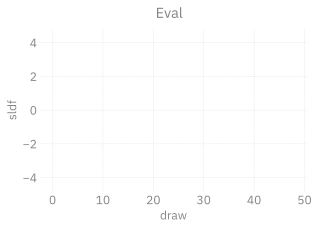

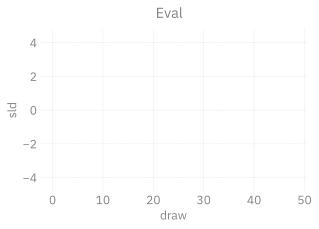

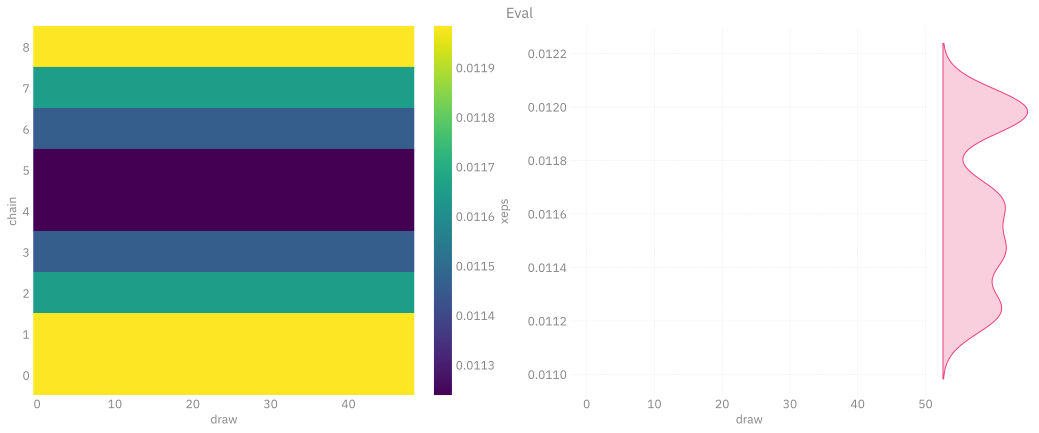

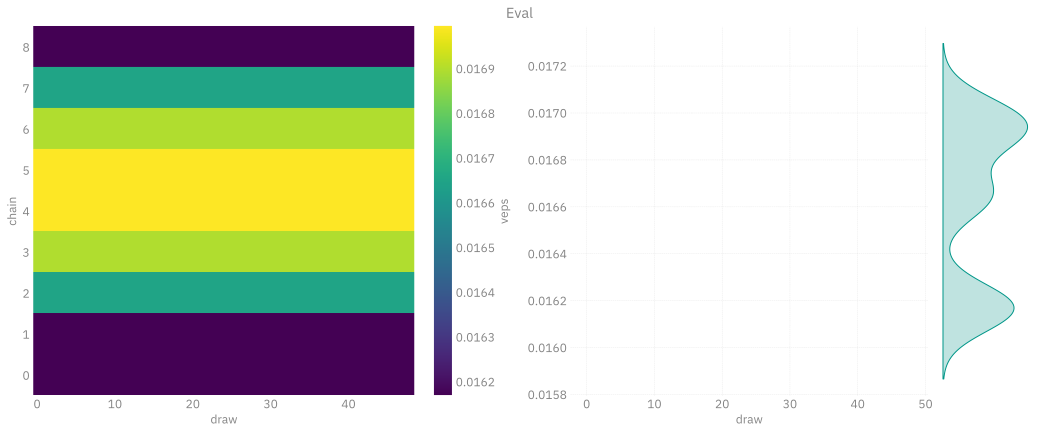

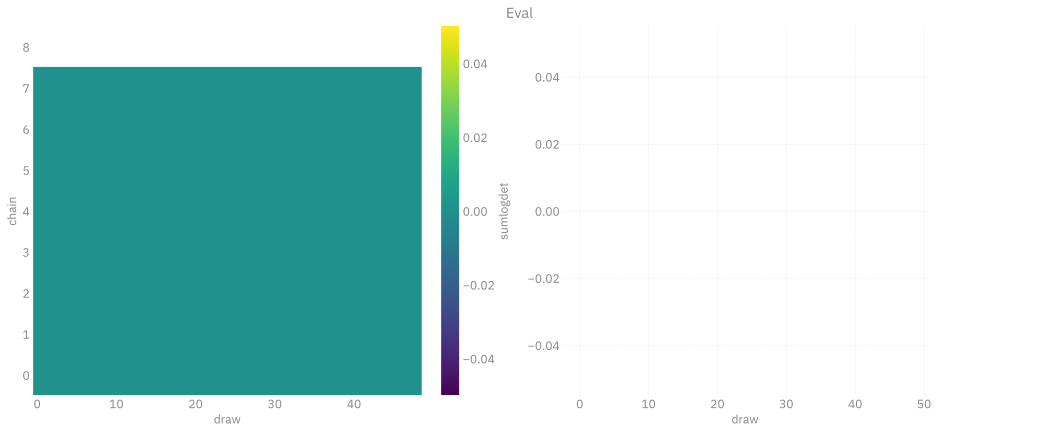

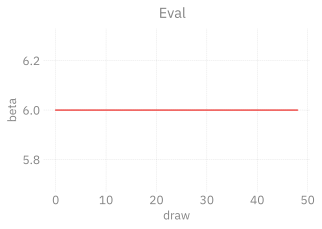

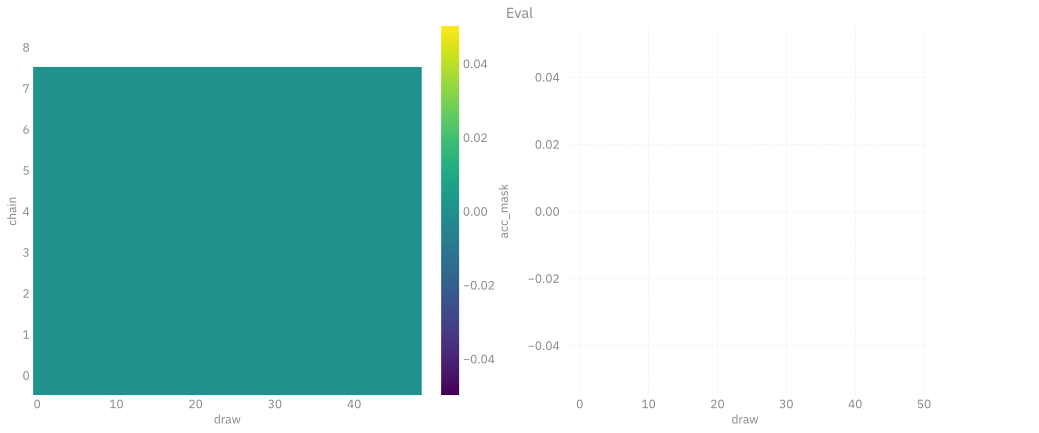

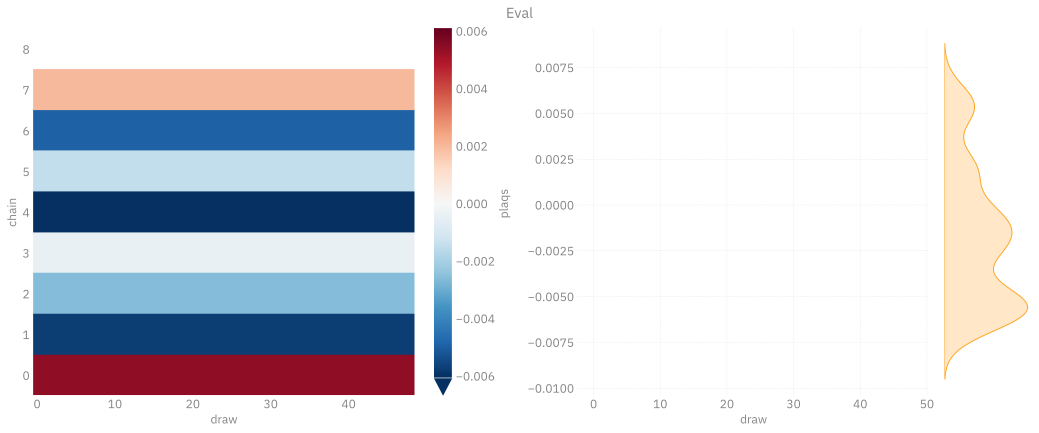

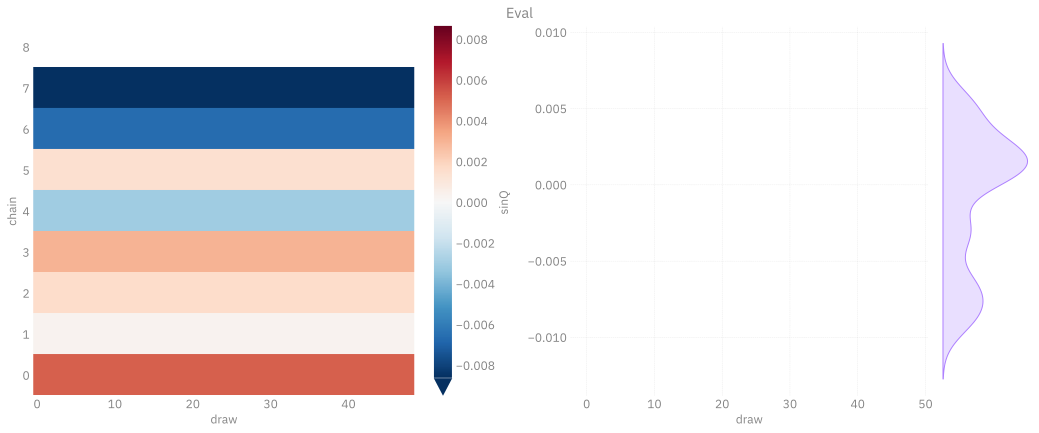

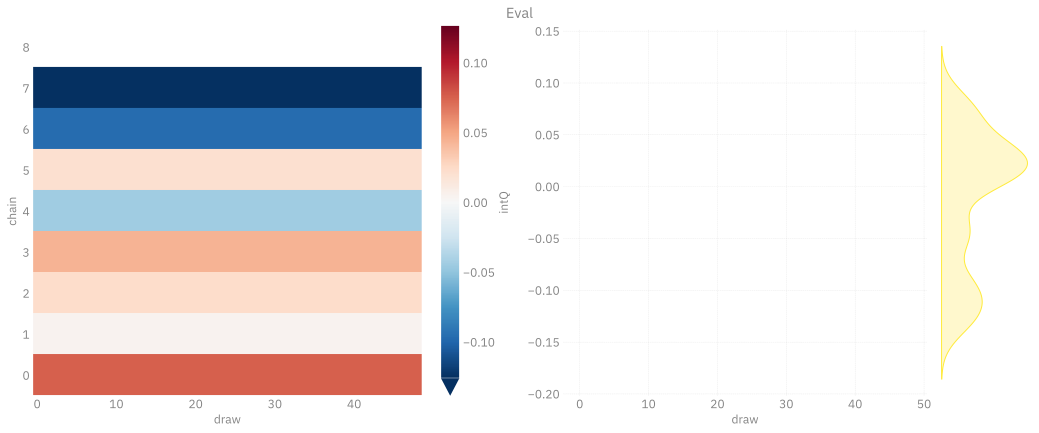

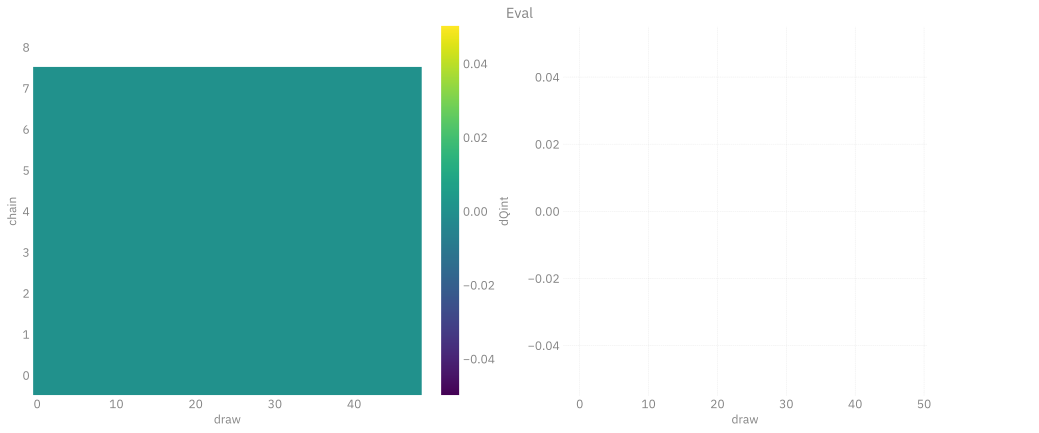

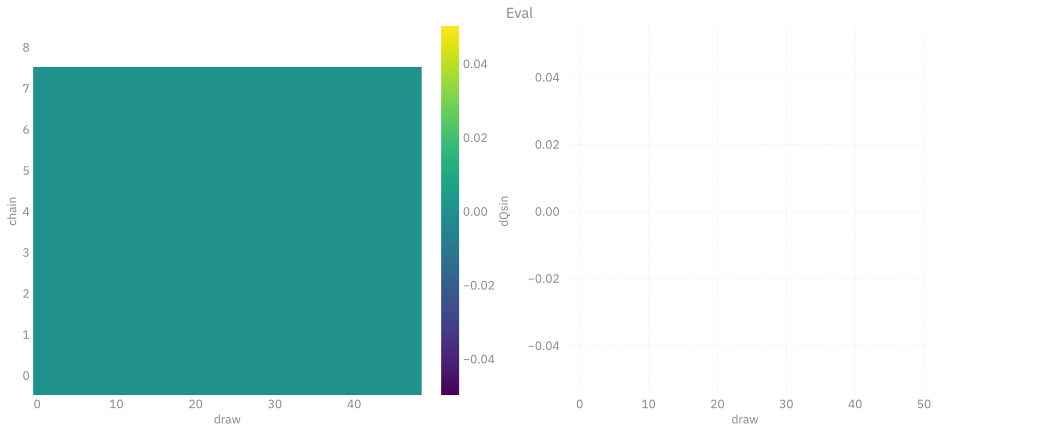

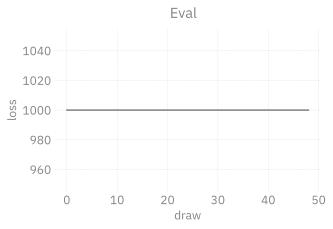

In [15]:
dataset_eval = history_eval.get_dataset()
_ = history_eval.plot_all(title='Eval')

In [16]:
xeval = ptExpSU3.trainer.dynamics.unflatten(xeval)
logger.info(f"checkSU(x_eval): {g.checkSU(xeval)}")
logger.info(f"checkSU(x_eval): {g.checkSU(g.projectSU(xeval))}")

[2025-04-30 16:08:39][I][ipykernel_24193/2193937887:2:ezpz.log] checkSU(x_eval): (tensor[8] f64 x∈[1.387e-16, 1.458e-16] μ=1.433e-16 σ=2.311e-18 [1.425e-16, 1.457e-16, 1.387e-16, 1.458e-16, 1.436e-16, 1.422e-16, 1.432e-16, 1.447e-16], tensor[8] f64 x∈[5.173e-16, 7.840e-16] μ=6.551e-16 σ=1.029e-16 [7.840e-16, 6.628e-16, 5.173e-16, 6.288e-16, 6.088e-16, 7.452e-16, 5.299e-16, 7.638e-16])

[2025-04-30 16:08:39][I][ipykernel_24193/2193937887:3:ezpz.log] checkSU(x_eval): (tensor[8] f64 x∈[1.352e-16, 1.451e-16] μ=1.409e-16 σ=3.802e-18 [1.451e-16, 1.352e-16, 1.431e-16, 1.416e-16, 1.366e-16, 1.445e-16, 1.378e-16, 1.430e-16], tensor[8] f64 x∈[4.654e-16, 7.451e-16] μ=5.900e-16 σ=9.667e-17 [7.451e-16, 6.309e-16, 4.961e-16, 6.874e-16, 4.654e-16, 6.100e-16, 5.204e-16, 5.651e-16])

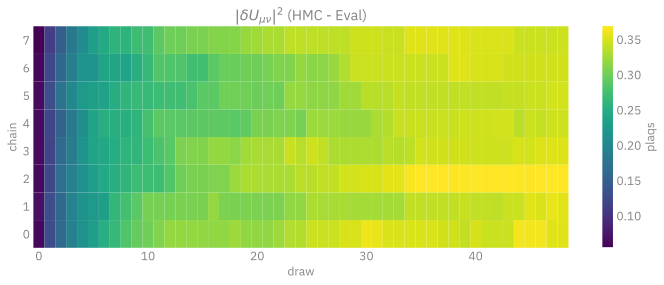

In [17]:
import matplotlib.pyplot as plt
pdiff = dataset_eval.plaqs - dataset_hmc.plaqs
pdiff
import xarray as xr

fig, ax = plt.subplots(figsize=(12, 4))
(pdiff ** 2).plot(ax=ax)  #, robust=True)
ax.set_title(r"$\left|\delta U_{\mu\nu}\right|^{2}$ (HMC - Eval)")
outfile = Path(EVAL_DIR).joinpath('pdiff.svg')
#%xmode fig.savefig(outfile.as_posix(), dpi=400, bbox_inches='tight')
plt.show()